## Data

In [3]:
import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs

data = torch.load('data/demonstrate/data_imit.pt')
human_pos_per_ep = []
prev_val = data[3][0].item()
ep_pos = []
for i in range(len(data[0])) :
    hum_pos, val = data[1][i], data[3][i]
    if abs(val.item()-prev_val) > 1e-1 :
        human_pos_per_ep.append(ep_pos)
        ep_pos=[]
    ep_pos.append(hum_pos)
    prev_val = val
    if i==len(data[0])-1 :
        human_pos_per_ep.append(ep_pos)

In [4]:
#torch.save(human_pos_per_ep, 'data/traj_data/human_traj.pt')

In [5]:
#human_pos_per_ep = torch.load('data/traj_data/human_traj.pt')

## Trajectory prediction

### N-step future position prediction


In [6]:
from policy.sail_traj_simple import TrajFeatureExtractor
from imitate import split_dataset
import torch.nn as nn
import configparser
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

#### Data

In [27]:
data_obs = torch.load('data/demonstrate/data_imit_mem.pt')
ds = ImitDatasetTraj(data_obs, None, 'cpu', horizon=10, sample=0.25)
train_dl, val_dl = split_dataset(ds, batch_size=128, percent_label=1)  

#### Prediction models

In [12]:
policy_conf = configparser.RawConfigParser()
policy_conf.read('configs/policy.config')
policy_nomem = policy_factory['sail_traj_simple']()
policy_mem = policy_factory['sail_traj_simple']()
policy_nomem.configure(policy_conf, max_obs=1)
policy_mem.configure(policy_conf, max_obs=9)

#### Training

In [23]:
def train(policy, train_dl, val_dl, device, n_epochs=30, pred_length=7, print_info=True):
    trajecory_feature_extr = policy.model.trajectory_fext
    prediciton_head = nn.Sequential(
                nn.Linear(trajecory_feature_extr.out_dim, 32),
                nn.ReLU(inplace=True),
                nn.Linear(32, 2))
    
    trajecory_feature_extr = trajecory_feature_extr.to(device)
    prediciton_head = prediciton_head.to(device)
    
    params = list(trajecory_feature_extr.parameters()) + list(prediciton_head.parameters())
    opt = torch.optim.Adam(params)
    
    train_losses = []
    val_losses = []
    for ep in range(n_epochs) :
        train_loss = 0
        valid_loss = 0
        lin_loss = 0
        train_iter = tqdm_notebook(train_dl, leave=False)
        for robot_states, human_states, action_targets, pos_seeds, neg_seeds in train_iter :
                bs, n_frames, n_human, _ = human_states.size()

                traj_features = trajecory_feature_extr(human_states.to(device))
                pred_pos = prediciton_head(traj_features)
                
                train_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos)**2).mean()

                opt.zero_grad()
                train_loss_batch.backward()
                opt.step()

                train_loss += train_loss_batch/len(train_dl)
        valid_iter = tqdm_notebook(val_dl, leave=False)
        for robot_states, human_states, action_targets, pos_seeds, neg_seeds in valid_iter :

                #linear motion model loss
                pred_pos_lin = human_states[:, -1, :, :2] + (human_states[:, -1, :, 2:] * pred_length)
                lin_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos_lin.to(device))**2).mean()
                lin_loss += lin_loss_batch/len(val_dl)


                #model_loss
                with torch.no_grad() :
                    traj_features = trajecory_feature_extr(human_states.to(device))
                    pred_pos = prediciton_head(traj_features)

                    valid_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos)**2).mean()
                    valid_loss += valid_loss_batch/len(val_dl)
        if print_info :
            print('Epoch {} | Train loss {:.4f} | Valid loss {:.4f}, | Linear loss {:.4f}'.format(ep, train_loss, valid_loss, lin_loss))
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
    return train_losses, val_losses

#### Test


In [18]:
train_loss, valid_loss = train(policy_mem, train_dl, val_dl, 'cuda')

Epoch 0 | Train loss 0.1475 | Valid loss 0.0150, | Linear loss 3.0458


Epoch 1 | Train loss 0.0136 | Valid loss 0.0134, | Linear loss 3.0453


Epoch 2 | Train loss 0.0119 | Valid loss 0.0117, | Linear loss 3.0461


Epoch 3 | Train loss 0.0106 | Valid loss 0.0103, | Linear loss 3.0457


Epoch 4 | Train loss 0.0099 | Valid loss 0.0094, | Linear loss 3.0462


Epoch 5 | Train loss 0.0093 | Valid loss 0.0090, | Linear loss 3.0453


Epoch 6 | Train loss 0.0090 | Valid loss 0.0089, | Linear loss 3.0455


Epoch 7 | Train loss 0.0088 | Valid loss 0.0087, | Linear loss 3.0455


Epoch 8 | Train loss 0.0086 | Valid loss 0.0089, | Linear loss 3.0454


Epoch 9 | Train loss 0.0084 | Valid loss 0.0084, | Linear loss 3.0456


Epoch 10 | Train loss 0.0082 | Valid loss 0.0084, | Linear loss 3.0457


Epoch 11 | Train loss 0.0079 | Valid loss 0.0085, | Linear loss 3.0461


Epoch 12 | Train loss 0.0076 | Valid loss 0.0075, | Linear loss 3.0458


Epoch 13 | Train loss 0.0074 | Valid loss 0.0078, | Linear loss 3.0455


Epoch 14 | Train loss 0.0073 | Valid loss 0.0073, | Linear loss 3.0455


Epoch 15 | Train loss 0.0071 | Valid loss 0.0074, | Linear loss 3.0451


Epoch 16 | Train loss 0.0070 | Valid loss 0.0070, | Linear loss 3.0458


Epoch 17 | Train loss 0.0068 | Valid loss 0.0068, | Linear loss 3.0457


Epoch 18 | Train loss 0.0066 | Valid loss 0.0067, | Linear loss 3.0458


Epoch 19 | Train loss 0.0065 | Valid loss 0.0066, | Linear loss 3.0455


Epoch 20 | Train loss 0.0064 | Valid loss 0.0064, | Linear loss 3.0460


Epoch 21 | Train loss 0.0063 | Valid loss 0.0067, | Linear loss 3.0454


Epoch 22 | Train loss 0.0062 | Valid loss 0.0065, | Linear loss 3.0458


Epoch 23 | Train loss 0.0061 | Valid loss 0.0065, | Linear loss 3.0458


Epoch 24 | Train loss 0.0061 | Valid loss 0.0064, | Linear loss 3.0458


Epoch 25 | Train loss 0.0060 | Valid loss 0.0062, | Linear loss 3.0452


Epoch 26 | Train loss 0.0059 | Valid loss 0.0061, | Linear loss 3.0457


Epoch 27 | Train loss 0.0059 | Valid loss 0.0061, | Linear loss 3.0457


Epoch 28 | Train loss 0.0058 | Valid loss 0.0063, | Linear loss 3.0459


Epoch 29 | Train loss 0.0058 | Valid loss 0.0061, | Linear loss 3.0455


In [19]:
train_loss_n, valid_loss_n = train(policy_nomem, train_dl, val_dl, 'cuda')

Epoch 0 | Train loss 0.1508 | Valid loss 0.0144, | Linear loss 3.0457


Epoch 1 | Train loss 0.0133 | Valid loss 0.0125, | Linear loss 3.0460


Epoch 2 | Train loss 0.0119 | Valid loss 0.0114, | Linear loss 3.0456


Epoch 3 | Train loss 0.0110 | Valid loss 0.0106, | Linear loss 3.0458


Epoch 4 | Train loss 0.0104 | Valid loss 0.0101, | Linear loss 3.0458


Epoch 5 | Train loss 0.0102 | Valid loss 0.0101, | Linear loss 3.0456


Epoch 6 | Train loss 0.0099 | Valid loss 0.0096, | Linear loss 3.0458


Epoch 7 | Train loss 0.0096 | Valid loss 0.0093, | Linear loss 3.0458


Epoch 8 | Train loss 0.0095 | Valid loss 0.0096, | Linear loss 3.0457


Epoch 9 | Train loss 0.0093 | Valid loss 0.0091, | Linear loss 3.0460


Epoch 10 | Train loss 0.0091 | Valid loss 0.0093, | Linear loss 3.0457


Epoch 11 | Train loss 0.0090 | Valid loss 0.0086, | Linear loss 3.0461


Epoch 12 | Train loss 0.0087 | Valid loss 0.0087, | Linear loss 3.0457


Epoch 13 | Train loss 0.0084 | Valid loss 0.0082, | Linear loss 3.0457


Epoch 14 | Train loss 0.0081 | Valid loss 0.0082, | Linear loss 3.0460


Epoch 15 | Train loss 0.0079 | Valid loss 0.0077, | Linear loss 3.0458


Epoch 16 | Train loss 0.0076 | Valid loss 0.0075, | Linear loss 3.0458


Epoch 17 | Train loss 0.0074 | Valid loss 0.0073, | Linear loss 3.0457


Epoch 18 | Train loss 0.0072 | Valid loss 0.0071, | Linear loss 3.0456


Epoch 19 | Train loss 0.0069 | Valid loss 0.0073, | Linear loss 3.0460


Epoch 20 | Train loss 0.0068 | Valid loss 0.0069, | Linear loss 3.0455


Epoch 21 | Train loss 0.0066 | Valid loss 0.0066, | Linear loss 3.0454


Epoch 22 | Train loss 0.0065 | Valid loss 0.0064, | Linear loss 3.0459


Epoch 23 | Train loss 0.0064 | Valid loss 0.0066, | Linear loss 3.0456


Epoch 24 | Train loss 0.0063 | Valid loss 0.0064, | Linear loss 3.0457


Epoch 25 | Train loss 0.0063 | Valid loss 0.0064, | Linear loss 3.0455


Epoch 26 | Train loss 0.0062 | Valid loss 0.0064, | Linear loss 3.0460


Epoch 27 | Train loss 0.0062 | Valid loss 0.0062, | Linear loss 3.0457


Epoch 28 | Train loss 0.0061 | Valid loss 0.0072, | Linear loss 3.0459


Epoch 29 | Train loss 0.0061 | Valid loss 0.0061, | Linear loss 3.0457


In [15]:
def get_scores(policy, valid_dl) :
    trajecory_feature_extr = policy.model.trajectory_fext
    iterator = tqdm_notebook(valid_dl, leave=False, desc='Scores computing')
    scores_stack = []
    for robot_states, human_states, action_targets, pos_seeds, neg_seeds in iterator :
        with torch.no_grad() :
            _, scores = trajecory_feature_extr(human_states, return_attention_scores=True)
            scores_stack.append(scores.mean(dim=-1))
    scores_stack = torch.cat(scores_stack, dim=0).mean(dim=0)
    return scores_stack
            
    

In [21]:
def test_preds_attention(train_dl, val_dl, device, n_epochs=5, max_pred_length=7) :
    scores_per_pred_length = []
    for pred_length in range(1, max_pred_length+1) :
        print(pred_length)
        policy_conf = configparser.RawConfigParser()
        policy_conf.read('configs/policy.config')
        policy_mem = policy_factory['sail_traj_simple']()
        policy_mem.configure(policy_conf, max_obs=9)
        train(policy_mem, train_dl, val_dl, device, n_epochs=n_epochs, pred_length=pred_length)
        scores_per_pred_length.append(get_scores(policy_mem, val_dl))
    return scores_per_pred_length
        
    

In [29]:
sp = test_preds_attention(train_dl, val_dl, 'cpu')

1


Epoch 0 | Train loss 0.1920 | Valid loss 0.0054, | Linear loss 0.1863


Epoch 1 | Train loss 0.0034 | Valid loss 0.0024, | Linear loss 0.1863


Epoch 2 | Train loss 0.0018 | Valid loss 0.0016, | Linear loss 0.1863


Epoch 3 | Train loss 0.0012 | Valid loss 0.0012, | Linear loss 0.1862


Epoch 4 | Train loss 0.0010 | Valid loss 0.0010, | Linear loss 0.1862


2


Epoch 0 | Train loss 0.2121 | Valid loss 0.0080, | Linear loss 0.7507


Epoch 1 | Train loss 0.0057 | Valid loss 0.0047, | Linear loss 0.7507


Epoch 2 | Train loss 0.0039 | Valid loss 0.0038, | Linear loss 0.7508


Epoch 3 | Train loss 0.0033 | Valid loss 0.0035, | Linear loss 0.7507


Epoch 4 | Train loss 0.0030 | Valid loss 0.0038, | Linear loss 0.7507


3


Epoch 0 | Train loss 0.2200 | Valid loss 0.0121, | Linear loss 1.7045


Epoch 1 | Train loss 0.0096 | Valid loss 0.0087, | Linear loss 1.7042


Epoch 2 | Train loss 0.0077 | Valid loss 0.0078, | Linear loss 1.7042


Epoch 3 | Train loss 0.0069 | Valid loss 0.0076, | Linear loss 1.7041


Epoch 4 | Train loss 0.0065 | Valid loss 0.0071, | Linear loss 1.7042


4


Epoch 0 | Train loss 0.2517 | Valid loss 0.0180, | Linear loss 3.0581


Epoch 1 | Train loss 0.0152 | Valid loss 0.0149, | Linear loss 3.0577


Epoch 2 | Train loss 0.0129 | Valid loss 0.0133, | Linear loss 3.0568


Epoch 3 | Train loss 0.0119 | Valid loss 0.0121, | Linear loss 3.0586


Epoch 4 | Train loss 0.0110 | Valid loss 0.0119, | Linear loss 3.0578


5


Epoch 0 | Train loss 0.2589 | Valid loss 0.0274, | Linear loss 4.8259


Epoch 1 | Train loss 0.0241 | Valid loss 0.0225, | Linear loss 4.8250


Epoch 2 | Train loss 0.0212 | Valid loss 0.0211, | Linear loss 4.8245


Epoch 3 | Train loss 0.0199 | Valid loss 0.0212, | Linear loss 4.8262


Epoch 4 | Train loss 0.0189 | Valid loss 0.0195, | Linear loss 4.8254


6


Epoch 0 | Train loss 0.2965 | Valid loss 0.0390, | Linear loss 7.0179


Epoch 1 | Train loss 0.0350 | Valid loss 0.0338, | Linear loss 7.0183


Epoch 2 | Train loss 0.0311 | Valid loss 0.0306, | Linear loss 7.0197


Epoch 3 | Train loss 0.0288 | Valid loss 0.0294, | Linear loss 7.0215


Epoch 4 | Train loss 0.0271 | Valid loss 0.0259, | Linear loss 7.0189


7


Epoch 0 | Train loss 0.2946 | Valid loss 0.0504, | Linear loss 9.6527


Epoch 1 | Train loss 0.0448 | Valid loss 0.0421, | Linear loss 9.6552


Epoch 2 | Train loss 0.0381 | Valid loss 0.0357, | Linear loss 9.6541


Epoch 3 | Train loss 0.0331 | Valid loss 0.0323, | Linear loss 9.6526


Epoch 4 | Train loss 0.0302 | Valid loss 0.0305, | Linear loss 9.6529


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

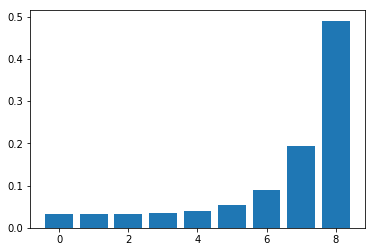

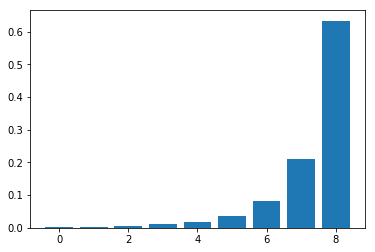

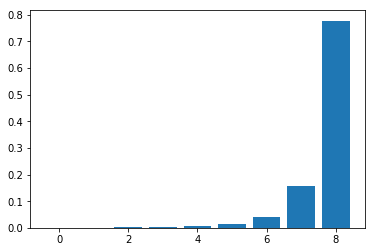

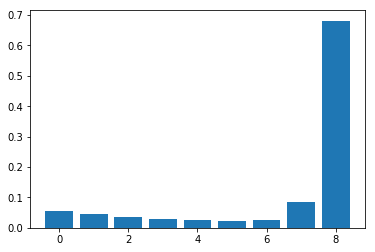

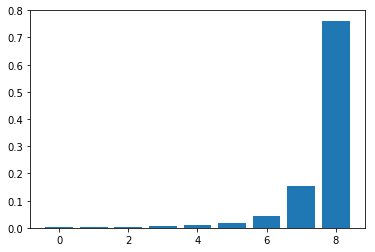

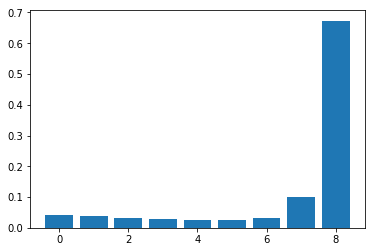

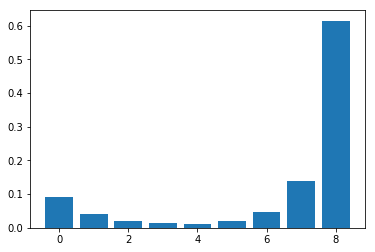

In [44]:
for s in sp :
    plt.bar(range(s.size(0)), s)
    plt.show()

In [1]:
import torch 
import os
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pickle
from utils.dataset import ImitDataset, ImitDatasetTraj
from policy.sail_traj import ExtendedNetworkTraj
from policy.policy_factory import policy_factory
import configparser
import gym
import sys
sys.path.append('..')
from crowd_sim.envs.utils.robot import Robot
from crowd_sim.envs.crowd_sim import CrowdSim
from crowd_nav.utils.explorer import ExplorerDs

In [2]:
from policy.sail_traj_simple import TrajFeatureExtractor
from imitate import split_dataset
import torch.nn as nn
import configparser
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [7]:
data_obs = torch.load('data/demonstrate/data_imit_mem.pt')
ds = ImitDatasetTraj(data_obs, None, 'cpu', horizon=10)
train_dl, val_dl = split_dataset(ds, batch_size=128, percent_label=0.4)  
policy_conf = configparser.RawConfigParser()
policy_conf.read('configs/policy.config')
policy_nomem = policy_factory['sail_traj_simple']()
policy_mem = policy_factory['sail_traj_simple']()
policy_nomem.configure(policy_conf, max_obs=1)
policy_mem.configure(policy_conf, max_obs=9)

SyntaxError: invalid syntax (<ipython-input-7-d950b1537165>, line 3)

In [8]:
def train(policy, train_dl, val_dl, device, n_epochs=30, pred_length=7) :
    trajecory_feature_extr = policy.model.trajectory_fext
    pred_length = 4
    prediciton_head = nn.Sequential(
                nn.Linear(trajecory_feature_extr.out_dim, 32),
                nn.ReLU(inplace=True),
                nn.Linear(32, 2))
    
    trajecory_feature_extr = trajecory_feature_extr.to(device)
    prediciton_head = prediciton_head.to(device)
    
    params = list(trajecory_feature_extr.parameters()) + list(prediciton_head.parameters())
    opt = torch.optim.Adam(params)
    
    train_losses = []
    val_losses = []
    for ep in range(n_epochs) :
        train_loss = 0
        valid_loss = 0
        lin_loss = 0
        train_iter = tqdm_notebook(train_dl, leave=False)
        for robot_states, human_states, action_targets, pos_seeds, neg_seeds in train_iter :
                bs, n_frames, n_human, _ = human_states.size()

                traj_features = trajecory_feature_extr(human_states.to(device))
                pred_pos = prediciton_head(traj_features)
                
                train_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos)**2).mean()

                opt.zero_grad()
                train_loss_batch.backward()
                opt.step()

                train_loss += train_loss_batch/len(train_dl)
        valid_iter = tqdm_notebook(val_dl, leave=False)
        for robot_states, human_states, action_targets, pos_seeds, neg_seeds in valid_iter :

                #linear motion model loss
                pred_pos_lin = human_states[:, -1, :, :2] + (human_states[:, -1, :, 2:] * pred_length)
                lin_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos_lin.to(device))**2).mean()
                lin_loss += lin_loss_batch/len(val_dl)


                #model_loss
                with torch.no_grad() :
                    traj_features = trajecory_feature_extr(human_states.to(device))
                    pred_pos = prediciton_head(traj_features)

                    valid_loss_batch = ((neg_seeds[:, pred_length-1].to(device) - pred_pos)**2).mean()
                    valid_loss += valid_loss_batch/len(val_dl)
        print('Epoch {} | Train loss {:.4f} | Valid loss {:.4f}, | Linear loss {:.4f}'.format(ep, train_loss, valid_loss, lin_loss))
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
    return train_losses, val_losses